# 🧠 APVC – Projeto Final
## Sistema de Deteção e Classificação de Equipas de Futebol em Imagens de equipamentos

### 👥 Grupo G11
- **Bernardo Coelho**, nº 98445  
- **Rafael Alexandre Dias Andorinha**, nº 131000  
- **Nuno Martins**, nº 98863  
- **Pedro Fonte Santa**, nº 105306  

---

📅 **Data de entrega:** 15 de Julho  

📊 **Objetivo deste script:**
Este notebook tem como objetivo integrar o modelo YOLOv8, previamente treinado para a deteção de emblemas em camisolas de futebol, com uma rede neuronal convolucional (CNN) treinada para classificar o clube correspondente ao emblema detetado. O processo consiste em aplicar o YOLOv8 a imagens reais de jogadores, extrair as regiões com emblemas detetados e encaminhá-las para a CNN, que prevê o clube. Foram testadas duas abordagens distintas para o recorte da imagem com base nas bounding boxes do YOLO: uma com redução (`shrink`) e outra com expansão (`expand`) da área detetada. Ambas as estratégias foram comparadas através de métricas de desempenho e visualizações, incluindo matrizes de confusão e exemplos ilustrativos de classificações corretas, incorretas e sem deteção.

---

In [ ]:
import os
from PIL import Image
import torch
from torchvision import models, transforms
from ultralytics import YOLO
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import cv2


In [ ]:
# Caminhos
YOLO_MODEL_PATH = "runs_yolo/logo_detector/weights/best.pt"
CNN_MODEL_PATH = "/Users/pedrofs/ISCTE/Mestrado/ComputerVision/Projeto_CV/notebooks/new-classification/best_model.pt"
KIT_DATASET = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final"

# Dispositivo
DEVICE = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

# YOLO detector
detector = YOLO(YOLO_MODEL_PATH)

# Transformações da CNN
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.CenterCrop(224),
    transforms.ToTensor()
])

# Labels da CNN
DATASET_DIR = "/Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/augmented-flat-cnn-kit-dataset"
class_names = sorted([
    d for d in os.listdir(DATASET_DIR)
    if os.path.isdir(os.path.join(DATASET_DIR, d)) and not d.startswith(".")
])

# Modelo CNN
cnn = models.resnet18(pretrained=False)
cnn.fc = torch.nn.Linear(cnn.fc.in_features, len(class_names))
cnn.load_state_dict(torch.load(CNN_MODEL_PATH, map_location=DEVICE))
cnn = cnn.to(DEVICE)
cnn.eval()


In [5]:
def cnn_predict_from_yolo(image_path, factor):
    image = Image.open(image_path).convert("RGB")
    image_w, image_h = image.size

    results = detector(image_path, conf=0.3)
    if not results or not results[0].boxes or len(results[0].boxes.xywh) == 0:
        return None

    cx, cy, bw, bh = results[0].boxes.xywh[0]
    bw, bh = bw * factor, bh * factor

    x1 = int((cx - bw / 2).item())
    y1 = int((cy - bh / 2).item())
    x2 = int((cx + bw / 2).item())
    y2 = int((cy + bh / 2).item())  

    x1, y1 = max(x1, 0), max(y1, 0)
    x2, y2 = min(x2, image_w), min(y2, image_h)

    if x2 <= x1 or y2 <= y1:
        return None 

    cropped = image.crop((x1, y1, x2, y2))
    input_tensor = transform(cropped).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = cnn(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        return class_names[pred_idx]


### 📸 Leitura da imagem de teste e inferência com o YOLO

In [6]:
from collections import defaultdict

true_labels = []
preds_shrink = []
preds_expand = []

factors = {"shrink": 0.88, "expand": 1.3}

for liga in sorted(os.listdir(KIT_DATASET)):
    liga_path = os.path.join(KIT_DATASET, liga)
    if not os.path.isdir(liga_path): continue

    for clube in sorted(os.listdir(liga_path)):
        clube_path = os.path.join(liga_path, clube)
        if not os.path.isdir(clube_path): continue

        for filename in os.listdir(clube_path):
            if not filename.lower().endswith((".jpg", ".jpeg", ".png")): continue
            image_path = os.path.join(clube_path, filename)
            true_labels.append(clube)

            pred_s = cnn_predict_from_yolo(image_path, factors["shrink"])
            pred_e = cnn_predict_from_yolo(image_path, factors["expand"])

            preds_shrink.append(pred_s or "None")
            preds_expand.append(pred_e or "None")



image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/augsburg/augsburg.jpg: 640x640 1 logo, 53.2ms
Speed: 0.9ms preprocess, 53.2ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/augsburg/augsburg.jpg: 640x640 1 logo, 38.9ms
Speed: 0.8ms preprocess, 38.9ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/bayern/bayern.jpg: 640x640 1 logo, 36.9ms
Speed: 0.8ms preprocess, 36.9ms inference, 0.4ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/bayern/bayern.jpg: 640x640 1 lo

### 🔁 Comparação entre SHRINK e EXPAND nas bounding boxes

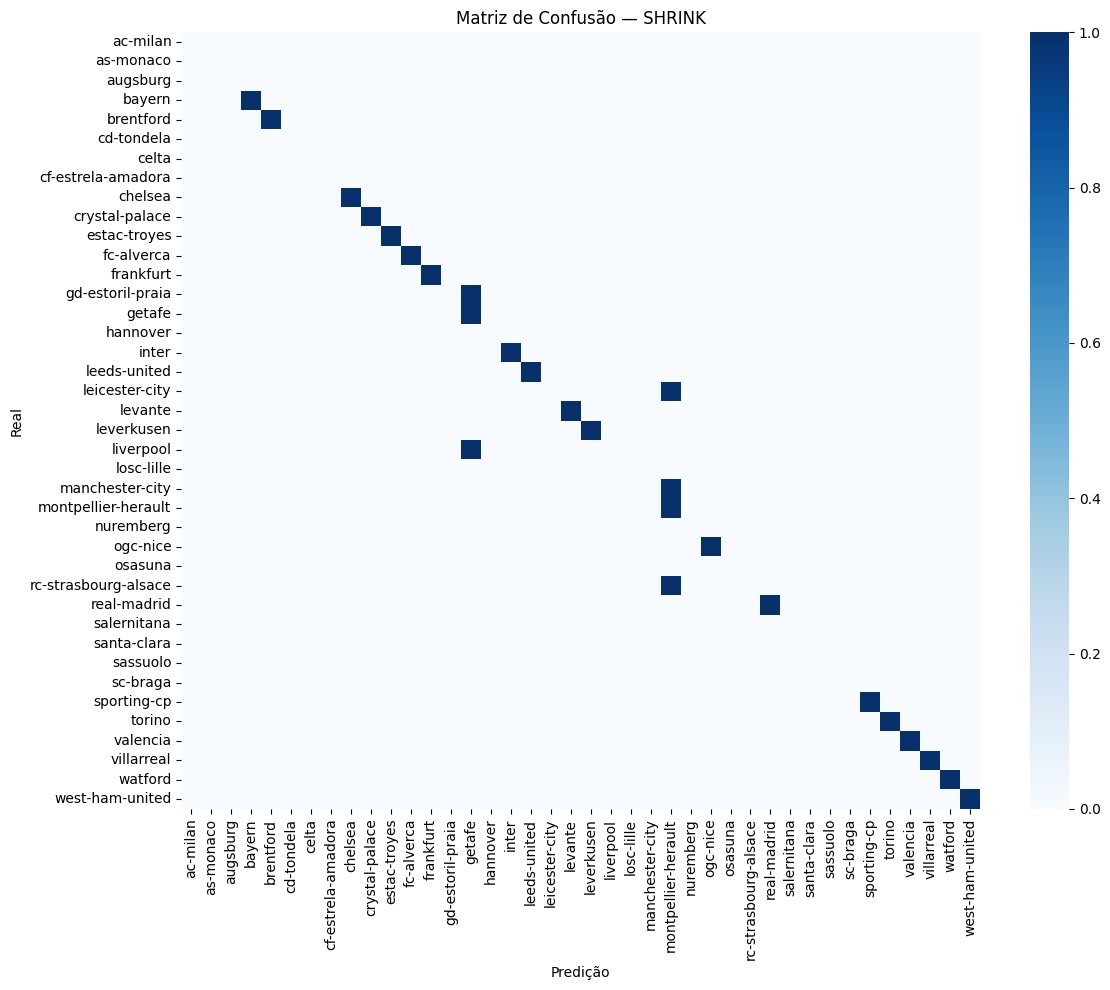

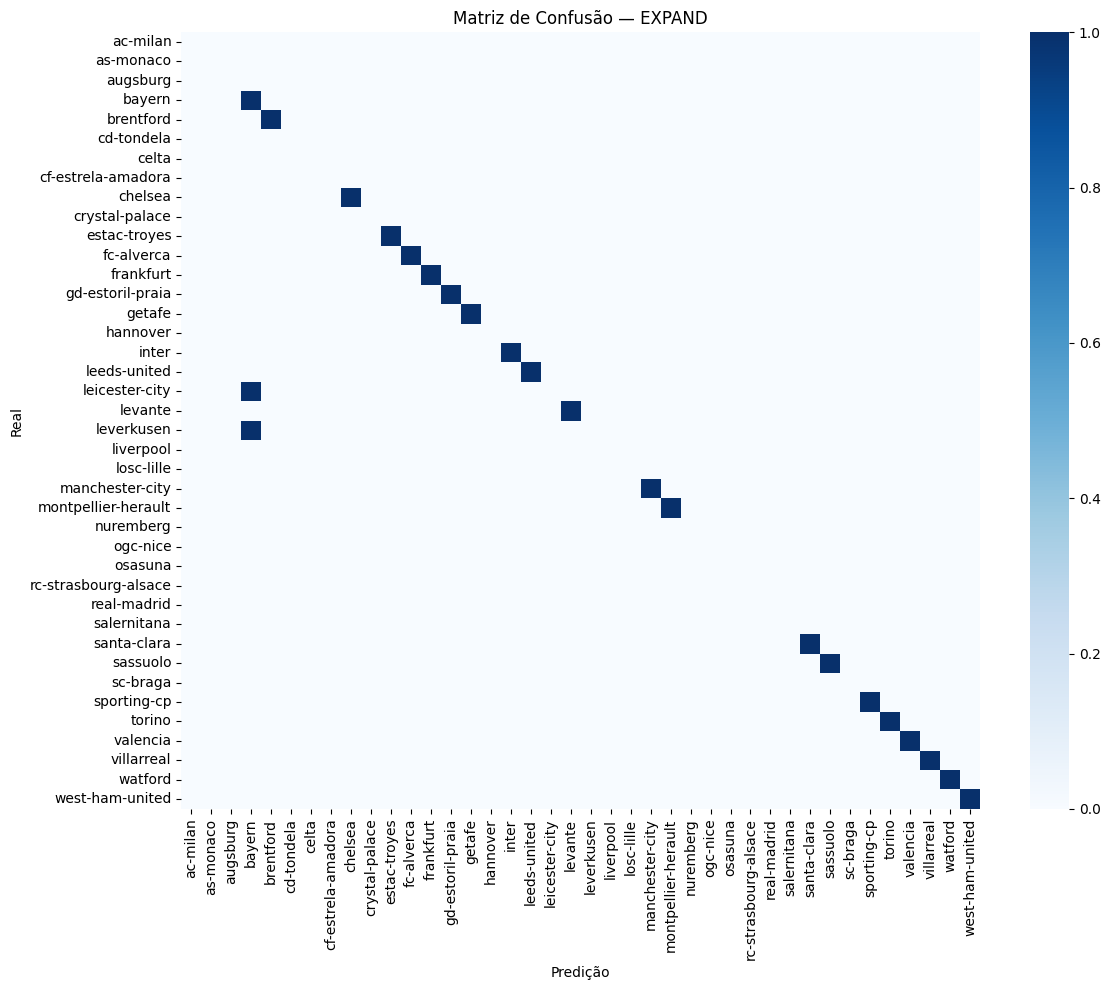

In [7]:
def plot_cm(y_true, y_pred, title):
    labels = sorted(list(set(y_true)))
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    plt.figure(figsize=(12, 10))
    sns.heatmap(cm, xticklabels=labels, yticklabels=labels, annot=False, fmt="d", cmap="Blues")
    plt.xlabel("Predição")
    plt.ylabel("Real")
    plt.title(title)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    plt.tight_layout()
    plt.show()

plot_cm(true_labels, preds_shrink, "Matriz de Confusão — SHRINK")
plot_cm(true_labels, preds_expand, "Matriz de Confusão — EXPAND")


In [8]:
def accuracy(y_true, y_pred):
    return np.mean([t == p for t, p in zip(y_true, y_pred)])

acc_s = accuracy(true_labels, preds_shrink)
acc_e = accuracy(true_labels, preds_expand)

print(f"\n Accuracy SHRINK: {acc_s:.2%}")
print(f" Accuracy EXPAND: {acc_e:.2%}")


 Accuracy SHRINK: 52.50%
 Accuracy EXPAND: 52.50%


In [ ]:
from glob import glob

# Guardar caminhos de todas as imagens (jpg ou png)
image_paths = sorted(glob(os.path.join(KIT_DATASET, "*", "*", "*.jpg"))) + \
              sorted(glob(os.path.join(KIT_DATASET, "*", "*", "*.png")))

print(f"Total de imagens disponíveis: {len(image_paths)}")

🔎 Total de imagens disponíveis: 40


### ✅❌ Visualização de Casos Específicos


image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/augsburg/augsburg.jpg: 640x640 1 logo, 52.1ms
Speed: 1.1ms preprocess, 52.1ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/bayern/bayern.jpg: 640x640 1 logo, 41.0ms
Speed: 0.8ms preprocess, 41.0ms inference, 0.3ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/frankfurt/frankfurt.jpg: 640x640 (no detections), 41.2ms
Speed: 0.7ms preprocess, 41.2ms inference, 0.2ms postprocess per image at shape (1, 3, 640, 640)

image 1/1 /Users/pedrofs/Library/CloudStorage/OneDrive-ISCTE-IUL/Mestrado/2ªSem/APVC/Projeto/dataset/yolo-kit-dataset-final/bundesliga/hannover/hannover.jp

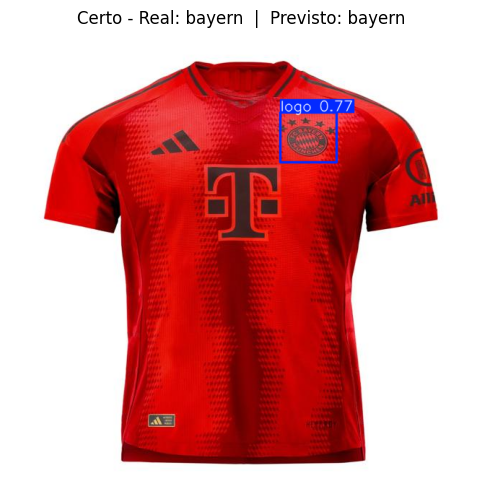

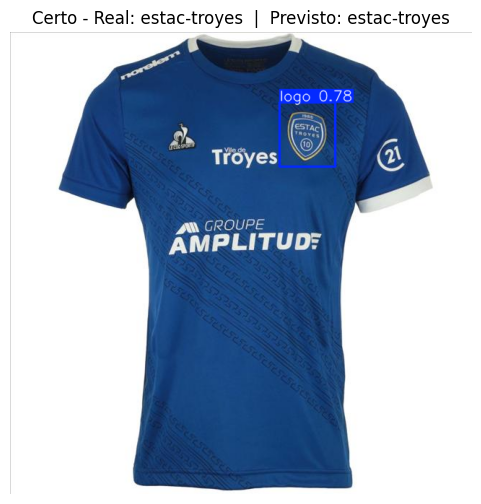

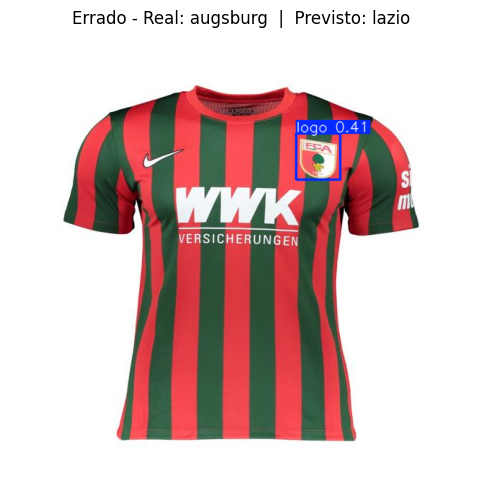

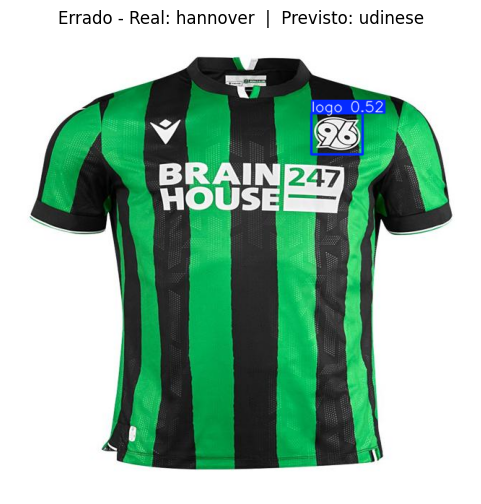

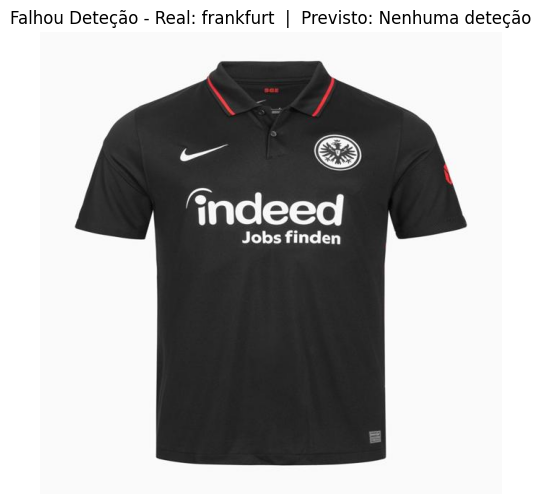

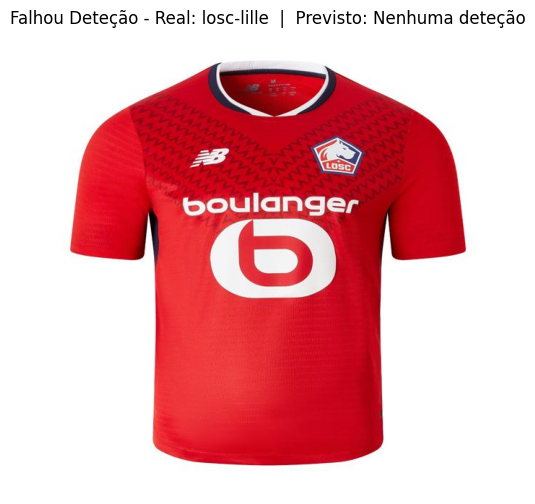

In [21]:
# Listas para armazenar exemplos
exemplos_certos = []
exemplos_errados = []
exemplos_sem_deteccao = []

MIN_BOX_SIZE = 30  # para ignorar deteções minúsculas

for i, path in enumerate(image_paths):
    true_label = true_labels[i]
    resultado = detector(path, conf=0.4)

    # Sem deteção YOLO
    if resultado[0].boxes is None or len(resultado[0].boxes) == 0:
        if len(exemplos_sem_deteccao) < 2:
            exemplos_sem_deteccao.append((path, true_label))
        continue

    # Filtrar boxes pequenas
    caixas = [
        box for box in resultado[0].boxes.xywh
        if box[2] > MIN_BOX_SIZE and box[3] > MIN_BOX_SIZE
    ]
    
    if len(caixas) == 0:
        if len(exemplos_sem_deteccao) < 2:
            exemplos_sem_deteccao.append((path, true_label))
        continue

    # Classificar com CNN
    cx, cy, bw, bh = caixas[0]
    x1 = int((cx - bw / 2).item())
    y1 = int((cy - bh / 2).item())
    x2 = int((cx + bw / 2).item())
    y2 = int((cy + bh / 2).item())

    image = Image.open(path).convert("RGB")
    image_w, image_h = image.size
    x1, y1 = max(0, x1), max(0, y1)
    x2, y2 = min(image_w, x2), min(image_h, y2)

    cropped = image.crop((x1, y1, x2, y2))
    input_tensor = transform(cropped).unsqueeze(0).to(DEVICE)

    with torch.no_grad():
        output = cnn(input_tensor)
        pred_idx = torch.argmax(output, dim=1).item()
        predicted = class_names[pred_idx]

    # Guardar exemplos
    if predicted == true_label and len(exemplos_certos) < 2:
        exemplos_certos.append((path, true_label, predicted, resultado))
    elif predicted != true_label and len(exemplos_errados) < 2:
        exemplos_errados.append((path, true_label, predicted, resultado))

    if (
        len(exemplos_certos) == 2 and
        len(exemplos_errados) == 2 and
        len(exemplos_sem_deteccao) == 2
    ):
        break

# Função para mostrar imagem
def mostrar_imagem_titulo(path, title, resultado=None):
    if resultado:
        img = resultado[0].plot()
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    else:
        img = Image.open(path).convert("RGB")
    plt.figure(figsize=(6, 6))
    plt.imshow(img)
    plt.title(title)
    plt.axis("off")
    plt.show()

# Mostrar exemplos corretos
for path, real, previsto, res in exemplos_certos:
    mostrar_imagem_titulo(path, f"Certo - Real: {real}  |  Previsto: {previsto}", res)

# Mostrar exemplos errados
for path, real, previsto, res in exemplos_errados:
    mostrar_imagem_titulo(path, f"Errado - Real: {real}  |  Previsto: {previsto}", res)

# Mostrar exemplos sem deteção
for path, real in exemplos_sem_deteccao:
    mostrar_imagem_titulo(path, f"Falhou Deteção - Real: {real}  |  Previsto: Nenhuma deteção")